In [1]:
#!pip install numpy 
#!pip install nbformat 
#!pip install matplotlib

import time
import csv
import numpy as np
import matplotlib.pyplot as plt
import copy
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go #for 3D plot
import concurrent.futures
import multiprocessing
import os

In [2]:
# Compute the Euclidean distance between two points.
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

# Generate possible gene values and binary representation of genes.
def gene_generator(min_range, max_range, m, n):
    num_of_genes = 2**n - 1
    interval = (max_range - min_range) / num_of_genes
    gene_value = []
    for i in range(num_of_genes+1):
        gene_value.append(min_range+i*interval)
    gene = [[*bin(i)[2:].zfill(n)] for i in range(0, num_of_genes+1)]
    return gene_value, gene

# Griewank function used as an objective function.
def griewank(x, start_time):
    x = x - (time.time()-start_time)/2
    sum_term = np.sum(x**2 / 4000)
    prod_term = np.prod(np.cos(x / np.sqrt(np.arange(1, len(x) + 1))))
    return float(1 + sum_term - prod_term)

# Rosenbrock function used as an objective function.
def rosenbrock(x, a=1, b=100):
    sum_term = np.sum((a - x[:-1])**2)
    prod_term = np.sum(b * (x[1:] - x[:-1]**2)**2)
    return (sum_term + prod_term)

# Sphere function used as an objective function.
def sphere(x):
    return np.sum(x**2)

# Ackley function used as an objective function. Adjust x based on elapsed time since start_time.
def ackley(x, start_time):
    x = x - 0.5*(time.time()-start_time)
    if np.all(x >= -20) and np.all(x <= 20):
        a=20 
        b=0.2 
        c=2*np.pi, 
        n = len(x)
        sum1 = np.sum(x**2)
        sum2 = np.sum(np.cos(c * x))
        term1 = -a * np.exp(-b * np.sqrt(sum1 / n))
        term2 = -np.exp(sum2 / n)
        return 20-(term1 + term2 + a + np.exp(1))
    else:
        return 0

# Rastrigin function used as an objective function.
def rastrigin(x):
    A = 10
    return A * len(x) + np.sum(x**2 - A * np.cos(2 * np.pi * x))

# Zakharov function used as an objective function.
def zakharov(x):
    sum1 = np.sum(x**2)
    sum2 = np.sum(0.5 * np.arange(1, len(x) + 1) * x)
    return sum1 + sum2**2 + sum2**4

# Function to generate values for the population based on the given objective function.
def population_value_generator(obj_fun, population, x_gene_value, y_gene_value, z_gene_value, start_time):
    population_values = []
    obj_func_values = []
    for chromosome in population: # Evaluate each chromosome in the population
        chromosome_values = []
        dim = 0
        for gene in chromosome:
            bin_str = ''.join(map(str, gene))
            dec_num = int(bin_str, 2)
            if dim == 0:
                chromosome_values.append(x_gene_value[dec_num])
            if dim == 1:
                chromosome_values.append(y_gene_value[dec_num])
            if dim == 2:
                chromosome_values.append(z_gene_value[dec_num])
            dim += 1
        if obj_fun == "Griewank":
            obj_func_value = griewank(np.array(chromosome_values), start_time)
        elif obj_fun == "Rosenbrock":
            obj_func_value = rosenbrock(np.array(chromosome_values))
        elif obj_fun == "Ackley":
            obj_func_value = ackley(np.array(chromosome_values),start_time)
        elif obj_fun == "Sphere":
            obj_func_value = sphere(np.array(chromosome_values))
        elif obj_fun == "Rastrigin":
            obj_func_value = rastrigin(np.array(chromosome_values))
        elif obj_fun == "Zakharov":
            obj_func_value = zakharov(np.array(chromosome_values))
        else:
            print("Give Correct Objective Function") 
        obj_func_values.append(obj_func_value)
        population_values.append(chromosome_values)
    return population_values, obj_func_values

# Select a subset of the population based on objective function values and optimization goal.
def thresholding(optm, obj_func_values, threshold):
    if optm == "min":
        selected_population_ind = np.argsort(obj_func_values)[:threshold]
    elif optm == "max":
        selected_population_ind = np.argsort(obj_func_values)[::-1][:threshold] #[:threshold]
    else:
        print("Define optimisation as maximise or minimise")
    return selected_population_ind

# Estimate fitness values for the selected population.
def fitness_estimation(selected_population, obj_func_values):
    fitness_values = []
    for ind in selected_population:
        #fitness = 1/(1 + obj_func_values[ind])
        fitness = (obj_func_values[ind])**4
        fitness_values.append(fitness)
    return(fitness_values)

 # Perform roulette wheel selection based on fitness values.
def Roulette_wheel(selected_population_ind, fitness_values, threshold, no_of_child):    
    sorted_indices = np.argsort(fitness_values)[::-1]  # Descending order
    ranks = np.zeros_like(sorted_indices)
    for rank, index in enumerate(sorted_indices):
        ranks[index] = rank + 1
    
    rank_sum = sum(ranks)
    fitness_probability = [(rank / rank_sum) for rank in ranks]  # Add a small value to avoid zero probability
    
    parents = set()
    while len(parents) < no_of_child:
        parent = np.random.choice(selected_population_ind, p=fitness_probability, size=2, replace=False).tolist()
        parents.add(tuple(parent))
    
    return tuple(parents)

# Perform crossover operation to generate children from parent chromosomes.
def crossover(parents, population, m):
    children = []
    for parent in parents:
        cross_pt = np.random.randint(1, m)
        child = np.concatenate((population[parent[0]][:cross_pt], population[parent[1]][cross_pt:]))
        children.append(child)
    return children

# Perform mutation on the children chromosomes.
def mutation(children,m,n):
    mutated_children = []
    for child in children:
        m_mutate = np.random.randint(0, m)
        n_mutate = np.random.randint(0, n)
        if child[m_mutate][n_mutate] == 0:
            child[m_mutate][n_mutate] = 1
        else:
            child[m_mutate][n_mutate] = 0
        mutated_children.append(child)
    return mutated_children

In [3]:
def genetic_algorithm(file_name, seed, p, m, n, threshold, no_of_child, x_min_range, x_max_range, y_min_range, y_max_range, z_min_range, z_max_range, obj_fun, num_of_mutation, optm, iter, start_time, previous_population):

    #np.random.seed(seed)
    f = []
    g = []
    f_lists = [[] for _ in range(p)]

    x_gene_value, x_gene = gene_generator(x_min_range, x_max_range, m, n)
    y_gene_value, y_gene = gene_generator(y_min_range, y_max_range, m, n)
    z_gene_value, z_gene = gene_generator(z_min_range, z_max_range, m, n)
    
    population  = previous_population

    for i in range(iter):

        population_values, obj_func_values = population_value_generator(obj_fun, population, x_gene_value, y_gene_value, z_gene_value, start_time)
            
        #Monitoring Variables
        for j, value in enumerate(obj_func_values):
            f_lists[j].append(value)
        if optm == "min":
            f.append(min(obj_func_values))
            g.append(population_values[obj_func_values.index(max(obj_func_values))])
        elif optm == "max":
            f.append(max(obj_func_values))
            g.append(population_values[obj_func_values.index(max(obj_func_values))])
        else:
            print("Define optimisation as maximise or minimise")

        #Thresholding
        selected_population_ind = thresholding(optm, obj_func_values, threshold)
        selected_population = []
        for i in selected_population_ind:
            selected_population.append(population[i])

        #Fitness Estimation
        fitness_values = fitness_estimation(selected_population_ind, obj_func_values)

        #Roulette_wheel
        parents = Roulette_wheel(selected_population_ind, fitness_values, threshold, no_of_child)

        # Crossover
        children = crossover(parents, population, m)
           
        if num_of_mutation == 0:
            new_children = children
        else:
            for i in range(num_of_mutation):
                new_children = mutation(children, m, n) #Issue with mutation. Mutate at many places
            
        # New Population
        population = selected_population + new_children
        
    value = f[len(f)-1]
    location = g[len(g)-1]
    index = f.index(value) + 1
    score = 100/(1+(index*value))
    result = {"value": value, "iteration": index, "location": location}
    fs = {"f": f, "f_lists": f_lists}
    
    return result, fs, population


In [4]:
#Intialisation
start_time = time.time()

errors = []
manual_errors = []
values = []
true_values = []
station_values = []
time_interval = []
est_points = []
actual_points = []

p = 6  # Population size / Number of chromosomes
m = 3 # Number of variables / genes
n = 5 # Number of digits / Alleles
threshold = 3 # Crossover threshold
no_of_child = 3
num_of_mutation = 3

#Dyamic Range
obj_fun = "Ackley" #"Griewank"/"Rosenbrock"
x_min_range = -10
x_max_range = 10
y_min_range = -10
y_max_range = 10
z_min_range = -10
z_max_range = 10
optm = "max" #"max"

iter = 100
times = 1
file = 'genetic_algorithm_output_steps.txt'

#seeds = [42, 123, 314, 2020, 2024, 314, 2718, 101, 999, 2023, 555, 777, 1001, 333, 888, 100, 200, 300, 400, 500, 600, 700, 1234, 5678, 9012, 3456, 7890]

for it in range(1,500):
    total_score, total_value, total_iteration = 0, 0, 0
    
    if it == 1:
        previous_population = np.random.randint(0, 2, size=(p, m, n)) # Random population generator
    else:
        previous_population = pre_population

    results = genetic_algorithm(file, 42, p, m, n, threshold, no_of_child, x_min_range, x_max_range, y_min_range, y_max_range, z_min_range, z_max_range, 
                                obj_fun, num_of_mutation, optm, iter, start_time, previous_population)
            
    result,fs, pre_population = results
    total_value += result['value']
    location = result['location']
    
    x = np.array([0, 0, 0])
    station_result = ackley(x, start_time)
    station_values.append(station_result)
    
    
    shifted_x = np.array([0, 0, 0]) + 0.5*(time.time() - start_time)
        
    true_result = ackley(shifted_x, start_time)
    true_values.append(true_result)
        
    avg_value, avg_iteration = total_value/times, total_iteration/times
    error = euclidean_distance(location, shifted_x)
    manual_error = euclidean_distance(np.array([0, 0, 0]), shifted_x)
    time_stamp = time.time() - start_time
    values.append(avg_value)
    errors.append(error)
    manual_errors.append(manual_error)
    time_interval.append(time_stamp)
    est_points.append(location)
    actual_points.append(shifted_x)
    
    print(f"\nTime: {time_stamp}s, \nShifted New Position: {shifted_x}, \nBest posible (Minima search) result: {true_result}")
    print("Euclidean Distance:", error)
    
    #Dynamic Range and threshold signal strength to trigger it
    if avg_value < 15 and it>10:
        populate_val = []
        x_gene_value, x_gene = gene_generator(x_min_range, x_max_range, m, n)
        y_gene_value, y_gene = gene_generator(y_min_range, y_max_range, m, n)
        z_gene_value, z_gene = gene_generator(z_min_range, z_max_range, m, n)
        for chromosome in previous_population:
            chromosome_values = []
            dim = 0
            for gene in chromosome:
                bin_str = ''.join(map(str, gene))
                dec_num = int(bin_str, 2)
                if dim == 0:
                    chromosome_values.append(x_gene_value[dec_num])
                if dim == 1:
                    chromosome_values.append(y_gene_value[dec_num])
                if dim == 2:
                    chromosome_values.append(z_gene_value[dec_num])
                dim += 1
            populate_val.append(chromosome_values)
        population_sum = [sum(col) for col in zip(*populate_val[:no_of_child])]
        
        #print(populate_val)
        #print(len(populate_val))
        #print(all_gene_value)
        #print(all_gene)
        min_range = -10
        max_range = 10
        x_min_range = min_range + chromosome_values[0]
        x_max_range = max_range + chromosome_values[0]
        y_min_range = min_range + chromosome_values[1]
        y_max_range = max_range + chromosome_values[1]
        z_min_range = min_range + chromosome_values[2]
        z_max_range = max_range + chromosome_values[2]
        
        print(x_min_range, x_max_range)
        print(y_min_range, y_max_range)
        print(z_min_range, z_max_range)
    
print("\nValue:", values)
print("\nErrors:", errors)


Time: 0.11743688583374023s, 
Shifted New Position: [0.05866671 0.05866671 0.05866671], 
Best posible (Minima search) result: 19.999984263549596
Euclidean Distance: 0.6002913067033308

Time: 0.22506475448608398s, 
Shifted New Position: [0.11248827 0.11248827 0.11248827], 
Best posible (Minima search) result: 19.99998998608592
Euclidean Distance: 0.6501605399621981

Time: 0.3313117027282715s, 
Shifted New Position: [0.16561007 0.16561007 0.16561007], 
Best posible (Minima search) result: 19.999989509216217
Euclidean Distance: 0.7080255068816075

Time: 0.44031739234924316s, 
Shifted New Position: [0.22011209 0.22011209 0.22011209], 
Best posible (Minima search) result: 19.99998998608592
Euclidean Distance: 0.7742936169402879

Time: 0.55137038230896s, 
Shifted New Position: [0.27564037 0.27564037 0.27564037], 
Best posible (Minima search) result: 19.999989032345002
Euclidean Distance: 0.8473134908973537

Time: 0.6637594699859619s, 
Shifted New Position: [0.33182442 0.33182442 0.33182442],

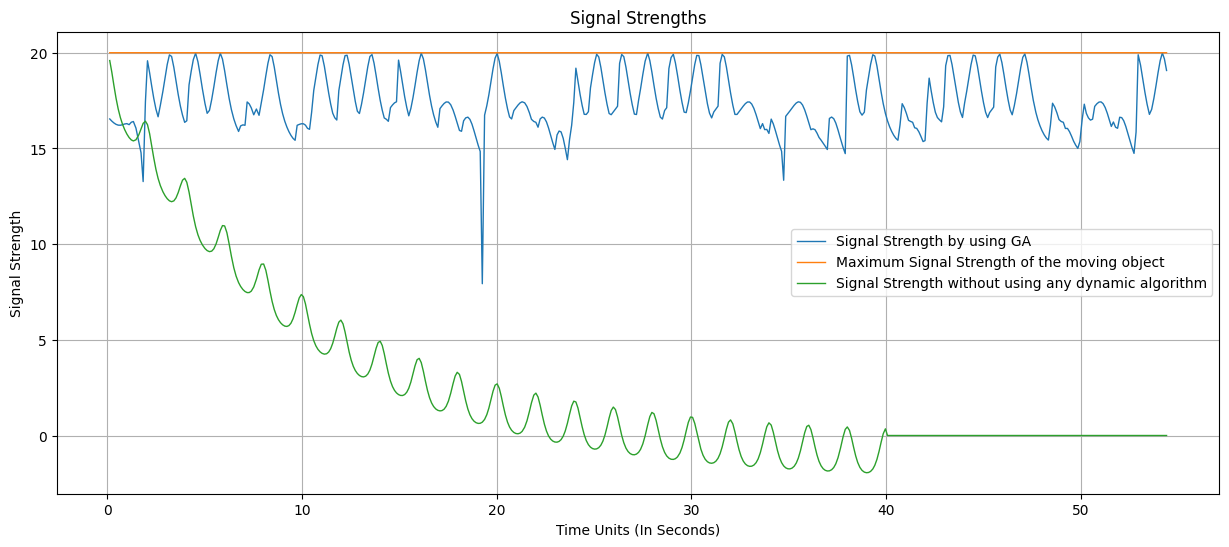

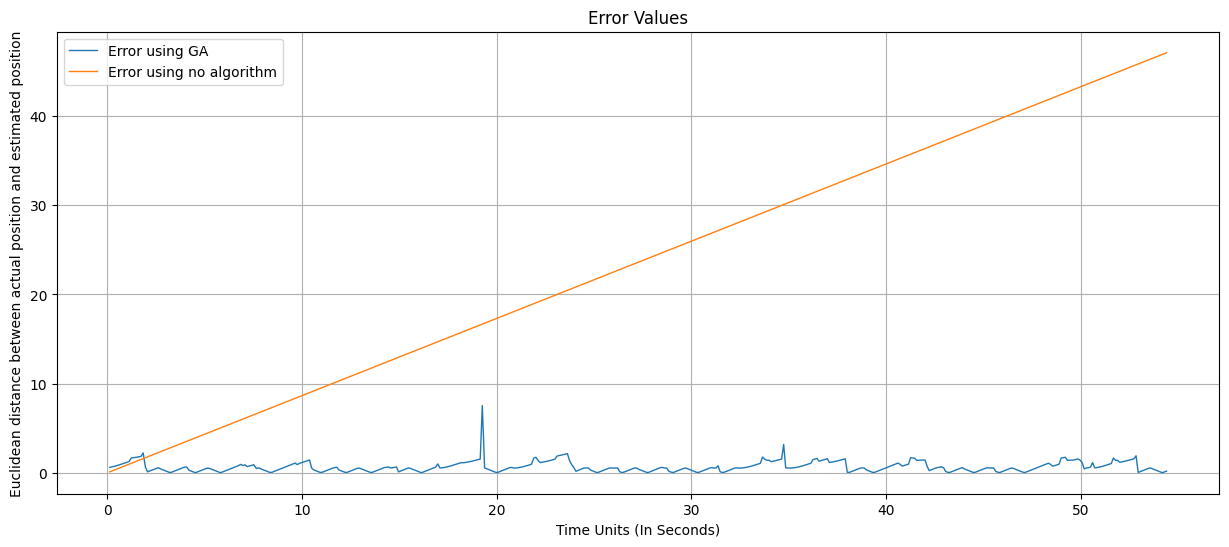

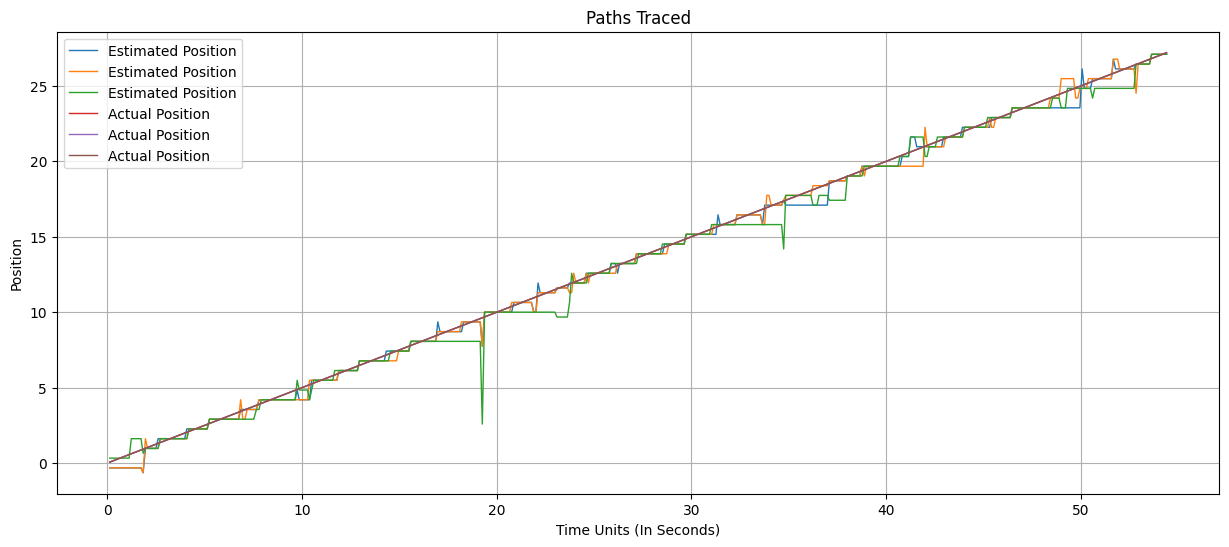

In [5]:
# Create a line plot
signal_strength = values
max_signal_strength = true_values
static_signal_strength = station_values

# Plot Signal Strengths
plt.figure(figsize=(15, 6))
plt.plot(time_interval, signal_strength, linewidth = '1', label="Signal Strength by using GA")
plt.plot(time_interval, max_signal_strength, label="Maximum Signal Strength of the moving object",linewidth = '1')
plt.plot(time_interval, static_signal_strength, label='Signal Strength without using any dynamic algorithm', linewidth = '1')
plt.title('Signal Strengths')
plt.xlabel('Time Units (In Seconds)')
plt.ylabel('Signal Strength')
plt.grid(True)
plt.legend()
plt.show()

#Error Values
plt.figure(figsize=(15, 6))
plt.plot(time_interval, errors, linewidth = '1', label='Error using GA')
plt.plot(time_interval, manual_errors, linewidth = '1', label='Error using no algorithm')
plt.title('Error Values')
plt.xlabel('Time Units (In Seconds)')
plt.ylabel('Euclidean distance between actual position and estimated position')
plt.grid(True)
plt.legend()
plt.show()

#Paths Traced
plt.figure(figsize=(15, 6))
plt.plot(time_interval, est_points, linewidth = '1', label='Estimated Position')
plt.plot(time_interval, actual_points, linewidth = '1', label='Actual Position')
plt.title('Paths Traced')
plt.xlabel('Time Units (In Seconds)')
plt.ylabel('Position')
plt.grid(True)
plt.legend()
plt.show()

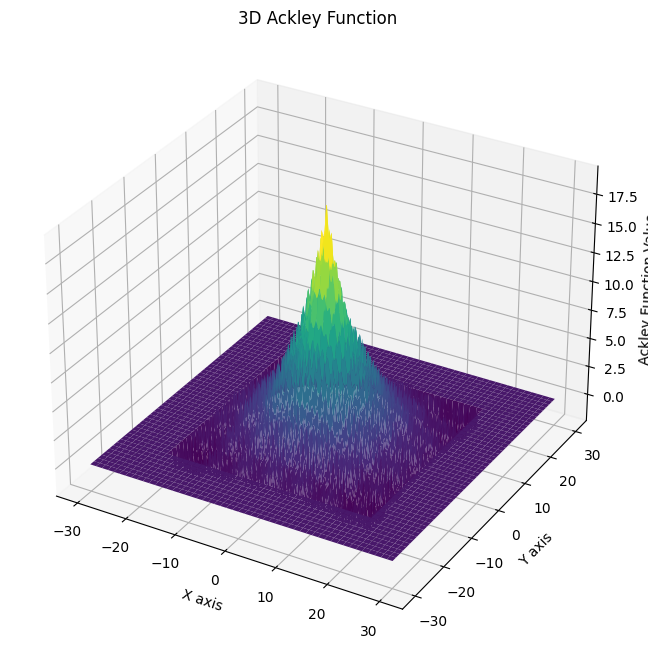

In [6]:
def ackley(x, y): 
    # Compute the Ackley function value for inputs x and y.
    result = 20 - (-20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2))) - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y))) + np.e + 20)
    
    # Create a mask to limit x and y within the range [-20, 20].
    mask = (x >= -20) & (x <= 20) & (y >= -20) & (y <= 20)
    
    # Set result to 0 for values of x and y outside the defined range.
    result[~mask] = 0
    
    # Return the computed result.
    return result              

# Generate 400 evenly spaced values between -30 and 30 for x and y.
x = np.linspace(-30, 30, 400)
y = np.linspace(-30, 30, 400)

# Create a 2D grid of x and y values.
X, Y = np.meshgrid(x, y)

# Calculate the Ackley function values over the grid.
Z = ackley(X, Y)

# Create a figure for 3D plotting.
fig = plt.figure(figsize=(12, 8))

# Add a 3D subplot to the figure.
ax = fig.add_subplot(111, projection='3d')

# Plot the surface of the Ackley function using the 'viridis' colormap.
ax.plot_surface(X, Y, Z, cmap='viridis')

# Set the title and labels for the axes.
ax.set_title('3D Ackley Function')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Ackley Function Value')

# Display the plot.
plt.show()

In [9]:
#Testing Block

max_range = -10
min_range =  10
m = 3
n = 5

num_of_genes = 2**n - 1
interval = (max_range - min_range) / num_of_genes
gene_value = []
for i in range(num_of_genes+1):
    gene_value.append(min_range+i*interval)
gene = [[*bin(i)[2:].zfill(n)] for i in range(0, num_of_genes+1)]
print(gene_value) 
print(gene)

[10.0, 9.35483870967742, 8.709677419354838, 8.064516129032258, 7.419354838709678, 6.774193548387097, 6.129032258064516, 5.483870967741936, 4.838709677419355, 4.193548387096774, 3.548387096774194, 2.903225806451613, 2.258064516129032, 1.612903225806452, 0.9677419354838719, 0.32258064516129004, -0.32258064516129004, -0.9677419354838701, -1.612903225806452, -2.258064516129032, -2.903225806451612, -3.548387096774194, -4.193548387096774, -4.838709677419354, -5.483870967741936, -6.129032258064516, -6.774193548387096, -7.419354838709676, -8.064516129032256, -8.70967741935484, -9.35483870967742, -10.0]
[['0', '0', '0', '0', '0'], ['0', '0', '0', '0', '1'], ['0', '0', '0', '1', '0'], ['0', '0', '0', '1', '1'], ['0', '0', '1', '0', '0'], ['0', '0', '1', '0', '1'], ['0', '0', '1', '1', '0'], ['0', '0', '1', '1', '1'], ['0', '1', '0', '0', '0'], ['0', '1', '0', '0', '1'], ['0', '1', '0', '1', '0'], ['0', '1', '0', '1', '1'], ['0', '1', '1', '0', '0'], ['0', '1', '1', '0', '1'], ['0', '1', '1', '1'